# Working with high-quality reference genomes 

Pf3D7_04_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1200490 | SO=chromosome
Pf3D7_05_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1343557 | SO=chromosome
Pf3D7_02_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=947102 | SO=chromosome
Pf3D7_09_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1541735 | SO=chromosome
Pf3D7_12_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=2271494 | SO=chromosome
Pf3D7_06_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1418242 | SO=chromosome
Pf3D7_14_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=3291936 | SO=chromosome
Pf3D7_03_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1067971 | SO=chromosome
Pf3D7_07_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1445207 | SO=chromosome
Pf3D7_13_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | le

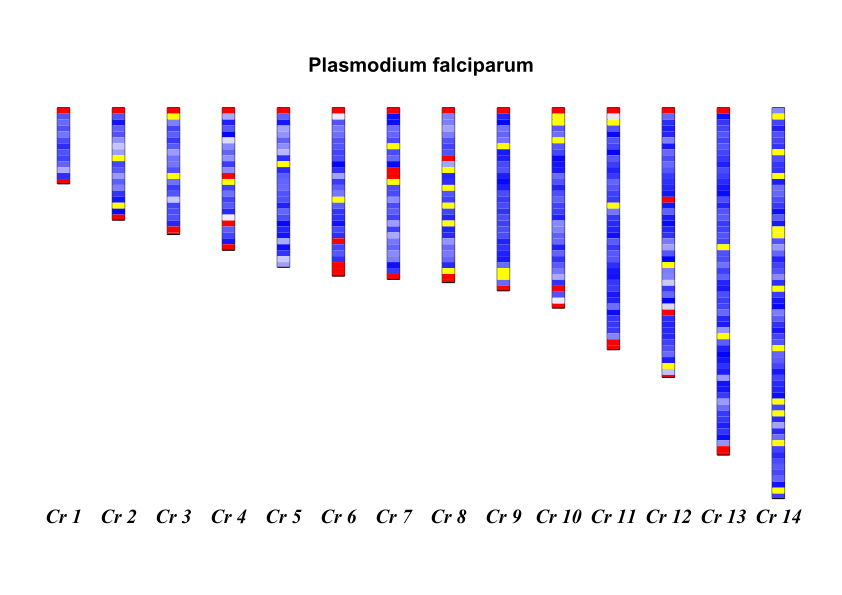

In [1]:
# Import necessary libraries
from IPython.core.display import Image
from reportlab.lib import colors
from reportlab.lib.units import cm
from Bio import SeqIO
from Bio.Graphics import BasicChromosome

# Define the name of the genome file
genome_name = 'PlasmoDB-13.0_Pfalciparum3D7_Genome.fasta'

# Read the genome sequences from the file
recs = SeqIO.parse(genome_name, 'fasta')
chroms = {}

# Iterate over the genome sequences and print their descriptions
for rec in recs:
    print(rec.description)

# +
# Import SeqUtils from Biopython
from Bio import SeqUtils

# Initialize dictionaries to store chromosome sizes and GC content
chrom_sizes = {}
chrom_GC = {}

# Read the genome sequences again
recs = SeqIO.parse(genome_name, 'fasta')
block_size = 50000
min_GC = 100.0
max_GC = 0.0

# Iterate over the genome sequences
for rec in recs:
    # Check if the sequence represents a chromosome
    if rec.description.find('SO=chromosome') == -1:
        continue
    # Extract chromosome number from the description
    chrom = int(rec.description.split('_')[1])
    chrom_GC[chrom] = []
    size = len(rec.seq)
    chrom_sizes[chrom] = size
    num_blocks = size // block_size + 1
    
    # Iterate over the sequence in blocks of defined size
    for block in range(num_blocks):
        start = block_size * block
        if block == num_blocks - 1:
            end = size
        else:
            end = block_size + start + 1
        block_seq = rec.seq[start:end]
        # Calculate the GC content of the block
        block_GC = SeqUtils.GC(block_seq)
        if block_GC < min_GC:
            min_GC = block_GC
        if block_GC > max_GC:
            max_GC = block_GC
        chrom_GC[chrom].append(block_GC)

# Print the minimum and maximum GC content found in the genome
print(min_GC, max_GC)

# +
# Extract the chromosome numbers and sort them
chroms = list(chrom_sizes.keys())
chroms.sort()

# Find the size of the largest chromosome
biggest_chrom = max(chrom_sizes.values())

# Initialize variables for color-coding the chromosomes based on GC content
my_genome = BasicChromosome.Organism(output_format="png")
my_genome.page_size = (29.7*cm, 21*cm)  # Set the page size

telomere_length = 10  # Define the length of telomeres

bottom_GC = 17.5  # Define the lower bound for GC content color
top_GC = 22.0  # Define the upper bound for GC content color

# Iterate over the chromosomes to create chromosome representations
for chrom in chroms:
    chrom_size = chrom_sizes[chrom]
    chrom_representation = BasicChromosome.Chromosome('Cr %d' % chrom)
    chrom_representation.scale_num = biggest_chrom

    tel = BasicChromosome.TelomereSegment()
    tel.scale = telomere_length
    chrom_representation.add(tel)

    num_blocks = len(chrom_GC[chrom])
    # Iterate over the GC content blocks and color-code them accordingly
    for block, gc in enumerate(chrom_GC[chrom]):
        my_GC = chrom_GC[chrom][block]
        body = BasicChromosome.ChromosomeSegment()
        if my_GC > top_GC:
            body.fill_color = colors.Color(1, 0, 0)  # Red color for high GC content
        elif my_GC < bottom_GC:
            body.fill_color = colors.Color(1, 1, 0)  # Yellow color for low GC content
        else:
            my_color = (my_GC - bottom_GC) / (top_GC - bottom_GC)
            body.fill_color = colors.Color(my_color, my_color, 1)
        if block < num_blocks - 1:
            body.scale = block_size
        else:
            body.scale = chrom_size % block_size
        chrom_representation.add(body)

    tel = BasicChromosome.TelomereSegment(inverted=True)
    tel.scale = telomere_length
    chrom_representation.add(tel)

    # Add the chromosome representation to the genome
    my_genome.add(chrom_representation)

# Draw the chromosome representations and save as an image
my_genome.draw("falciparum.png", "Plasmodium falciparum")

# Display the generated image
Image("falciparum.png")
# -

# Extracting Features

In [8]:
# Import necessary libraries
from collections import defaultdict
import requests
from Bio import ExPASy, SwissProt
import pandas as pd
import io

# Define the UniProt server URL
server = 'http://www.uniprot.org/uniprot'

# Function to send a request to the UniProt server
def do_request(server, ID='', **kwargs):
    params = ''
    req = requests.get('%s/%s%s' % (server, ID, params), params=kwargs)
    if not req.ok:
        req.raise_for_status()
    return req

# Send a request to the UniProt server to fetch information about the human gene 'p53'
# We are retrieving limited columns for 50 entries related to the gene 'p53' that have been reviewed
# Note: We might revisit this for KEGG data in the future
req = do_request(server, query='gene:p53 AND reviewed:yes', format='tab',
                 columns='id,entry name,length,organism,organism-id,database(PDB),database(HGNC)',
                 limit='50')

# Convert the response to a DataFrame using pandas
uniprot_list = pd.read_table(io.StringIO(req.text))
uniprot_list.rename(columns={'Organism ID': 'ID'}, inplace=True)

# Get the UniProt entry for the human gene 'p53'
p53_human = uniprot_list[
    (uniprot_list.ID == 9606) &
    (uniprot_list['Entry name'].str.contains('P53'))]['Entry'].iloc[0]

# Get the UniProt record for the specified entry (p53_human) using ExPASy
handle = ExPASy.get_sprot_raw(p53_human)
sp_rec = SwissProt.read(handle)

# Print some information about the UniProt record
print(sp_rec.entry_name, sp_rec.sequence_length, sp_rec.gene_name)
print(sp_rec.description)
print(sp_rec.organism, sp_rec.seqinfo)
print(sp_rec.sequence)

# Print comments and keywords associated with the UniProt record
print(sp_rec.comments)
print(sp_rec.keywords)

# Get a list of unique features in the UniProt record and print them
done_features = set()
print('Total features:', len(sp_rec.features))
for feature in sp_rec.features:
    if feature in done_features:
        continue
    else:
        done_features.add(feature)
        print(feature)

# Get a list of cross-references in the UniProt record, grouped by source, and print them
per_source = defaultdict(list)
for xref in sp_rec.cross_references:
    source = xref[0]
    per_source[source].append(xref[1:])
print(per_source.keys())

# Get a list of unique Gene Ontology (GO) annotations in the UniProt record and print them
done_GOs = set()
print('Annotation SOURCES:', len(per_source['GO']))
for annot in per_source['GO']:
    if annot[1][0] in done_GOs:
        continue
    else:
        done_GOs.add(annot[1][0])
        print(annot)


AgamP4_2L	VEuPathDB	protein_coding_gene	2358158	2431617	.	+	.	ID=AGAP004707;Name=para;description=voltage-gated sodium channel
AgamP4_2L +
AGAP004707-RA


NameError: name 'my_seq' is not defined

# Annotation of Genome

In [10]:
# Import necessary libraries
from collections import defaultdict
import gffutils
import sqlite3

# Define the URL for downloading the GFF file and the database file
gff_url = 'https://vectorbase.org/common/downloads/release-55/AgambiaePEST/gff/data/VectorBase-55_AgambiaePEST.gff'
gff_file = 'gambiae.gff'
db_file = 'ag.db'

# Create or connect to the database using gffutils
try:
    db = gffutils.create_db(gff_file + '.gz', db_file)
except sqlite3.OperationalError:
    db = gffutils.FeatureDB(db_file)

# Print the list of feature types in the GFF file
print(list(db.featuretypes()))

# Count the number of features for each feature type in the database
for feat_type in db.featuretypes():
    print(feat_type, db.count_features_of_type(feat_type))

# Get the unique sequence IDs present in the database
seqids = set()
for e in db.all_features():
    seqids.add(e.seqid)
for seqid in seqids:
    print(seqid)

# Initialize defaultdicts to count the number of mRNAs and exons for each gene
num_mRNAs = defaultdict(int)
num_exons = defaultdict(int)
max_exons = 0
max_span = 0

# Loop through each sequence ID and analyze the genes in the region
for seqid in seqids:
    cnt = 0
    for gene in db.region(seqid=seqid, featuretype='protein_coding_gene'):
        cnt += 1
        # Calculate the span of the gene (difference between start and end positions)
        span = abs(gene.start - gene.end) # strand
        if span > max_span:
            max_span = span
            max_span_gene = gene
        # Get the mRNA features for the gene and count the number of mRNAs for each gene
        my_mRNAs = list(db.children(gene, featuretype='mRNA'))
        num_mRNAs[len(my_mRNAs)] += 1
        # Determine if the gene has exons or not (exon_check will contain either gene or mRNA features)
        if len(my_mRNAs) == 0:
            exon_check = [gene]
        else:
            exon_check = my_mRNAs
        # Get the exon features and count the number of exons for each gene/mRNA
        for check in exon_check:
            my_exons = list(db.children(check, featuretype='exon'))
            num_exons[len(my_exons)] += 1
            # Track the gene with the maximum number of exons
            if len(my_exons) > max_exons:
                max_exons = len(my_exons)
                max_exons_gene = gene
    print(f'seqid {seqid}, number of genes {cnt}')

# Print the gene with the maximum number of exons and its count
print('Max number of exons: %s (%d)' % (max_exons_gene.id, max_exons))

# Print the gene with the maximum span and its span value
print('Max span: %s (%d)' % (max_span_gene.id, max_span))

# Print the counts of mRNAs and exons for each gene
print(num_mRNAs)
print(num_exons)


['CDS', 'RNase_MRP_RNA', 'RNase_P_RNA', 'SRP_RNA', 'exon', 'five_prime_UTR', 'lnc_RNA', 'mRNA', 'ncRNA', 'ncRNA_gene', 'pre_miRNA', 'protein_coding_gene', 'pseudogene', 'pseudogenic_transcript', 'rRNA', 'snRNA', 'snoRNA', 'tRNA', 'three_prime_UTR']
CDS 67394
RNase_MRP_RNA 1
RNase_P_RNA 1
SRP_RNA 3
exon 61590
five_prime_UTR 17472
lnc_RNA 2
mRNA 15125
ncRNA 4
ncRNA_gene 729
pre_miRNA 77
protein_coding_gene 13094
pseudogene 9
pseudogenic_transcript 9
rRNA 242
snRNA 35
snoRNA 2
tRNA 362
three_prime_UTR 12236
AgamP4_X
AgamP4_UNKN
AgamP4_2L
AgamP4_3R
AgamP4_Y_unplaced
AgamP4_3L
AgamP4_Mt
AgamP4_2R
seqid AgamP4_X, number of genes 1073
seqid AgamP4_UNKN, number of genes 478
seqid AgamP4_2L, number of genes 2950
seqid AgamP4_3R, number of genes 2692
seqid AgamP4_Y_unplaced, number of genes 2
seqid AgamP4_3L, number of genes 2216
seqid AgamP4_Mt, number of genes 13
seqid AgamP4_2R, number of genes 3670
Max number of exons: AGAP001660 (69)
Max span: AGAP006656 (365621)
defaultdict(<class 'int'>, 

# Working with Low-quality reference genomes 

In [4]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO, SeqUtils

# Download genome sequences of Anopheles gambiae and Aedes atroparvus
gambiae_name = 'gambiae.fa.gz'
atroparvus_name = 'atroparvus.fa.gz'

# Display descriptions of the sequences in the Anopheles gambiae genome
recs = SeqIO.parse(gzip.open(gambiae_name, 'rt', encoding='utf-8'), 'fasta')
for rec in recs:
    print(rec.description)

# Calculate the fraction of Ns (ambiguous nucleotides) in each contig of Anopheles gambiae genome
recs = SeqIO.parse(gzip.open(gambiae_name, 'rt', encoding='utf-8'), 'fasta')
chrom_Ns = {}
chrom_sizes = {}
for rec in recs:
    # Skip supercontigs in the genome
    if rec.description.find('supercontig') > -1:
        continue
    print(rec.description, rec.id, rec)
    chrom = rec.id.split('_')[1]
    if chrom in ['UNKN']:
        continue
    chrom_Ns[chrom] = []
    on_N = False
    curr_size = 0
    for pos, nuc in enumerate(rec.seq):
        if nuc in ['N', 'n']:
            curr_size += 1
            on_N = True
        else:
            if on_N:
                chrom_Ns[chrom].append(curr_size)
                curr_size = 0
            on_N = False
    if on_N:
        chrom_Ns[chrom].append(curr_size)
    chrom_sizes[chrom] = len(rec.seq)

# Display the fraction of Ns, number of Ns, and the maximum number of consecutive Ns for each contig
for chrom, Ns in chrom_Ns.items():
    size = chrom_sizes[chrom]
    if len(Ns) > 0:
        max_Ns = max(Ns)
    else:
        max_Ns = 'NA'
    print(f'{chrom} ({size}): %Ns ({round(100 * sum(Ns) / size, 1)}), num Ns: {len(Ns)}, max N: {max_Ns}')

# Calculate statistics for the sizes of sequences in the Aedes atroparvus genome
recs = SeqIO.parse(gzip.open(atroparvus_name, 'rt', encoding='utf-8'), 'fasta')
sizes = []
size_N = []
for rec in recs:
    size = len(rec.seq)
    sizes.append(size)
    count_N = 0
    for nuc in rec.seq:
        if nuc in ['n', 'N']:
            count_N += 1
    size_N.append((size, count_N / size))

# Display statistics for sequence sizes in the Aedes atroparvus genome
print(len(sizes), np.median(sizes), np.mean(sizes), max(sizes), min(sizes),
      np.percentile(sizes, 10), np.percentile(sizes, 90))

# Create a plot showing the fraction of Ns in contigs of different sizes in the Aedes atroparvus genome
small_split = 4800
large_split = 540000
fig, axs = plt.subplots(1, 3, figsize=(16, 9), dpi=300, squeeze=False, sharey=True)
xs, ys = zip(*[(x, 100 * y) for x, y in size_N if x <= small_split])
axs[0, 0].plot(xs, ys, '.')
xs, ys = zip(*[(x, 100 * y) for x, y in size_N if x > small_split and x <= large_split])
axs[0, 1].plot(xs, ys, '.')
axs[0, 1].set_xlim(small_split, large_split)
xs, ys = zip(*[(x, 100 * y) for x, y in size_N if x > large_split])
axs[0, 2].plot(xs, ys, '.')
axs[0, 0].set_ylabel('Fraction of Ns', fontsize=12)
axs[0, 1].set_xlabel('Contig size', fontsize=12)
fig.suptitle('Fraction of Ns per contig size', fontsize=26)
fig.savefig('frac.png')


BadGzipFile: Not a gzipped file (b'>A')

# Finding orthologues with the Ensembl REST API

In [5]:
import requests
 
ensembl_server = 'http://rest.ensembl.org'

def do_request(server, service, *args, **kwargs):
    # Prepare URL parameters for the request
    url_params = ''
    for a in args:
        if a is not None:
            url_params += '/' + a
    # Send a GET request to the specified service with the provided parameters and headers
    req = requests.get('%s/%s%s' % (server, service, url_params),
                       params=kwargs,
                       headers={'Content-Type': 'application/json'})
 
    # Check if the request was successful; if not, raise an exception
    if not req.ok:
        req.raise_for_status()
    return req.json()

# Get information about available species from Ensembl
answer = do_request(ensembl_server, 'info/species')
for i, sp in enumerate(answer['species']):
    print(i, sp['name'])

# Get information about external databases for Homo sapiens from Ensembl
ext_dbs = do_request(ensembl_server, 'info/external_dbs', 'homo_sapiens', filter='HGNC%')
print(ext_dbs)

# Lookup information about a gene with the symbol 'LCT' in Homo sapiens
answer = do_request(ensembl_server, 'lookup/symbol', 'homo_sapiens', 'LCT')
print(answer)
lct_id = answer['id']

# Get the DNA sequence of the gene with the specified Ensembl ID
lct_seq = do_request(ensembl_server, 'sequence/id', lct_id)
print(lct_seq)

# Get cross-references (Xrefs) for the gene with the specified Ensembl ID
lct_xrefs = do_request(ensembl_server, 'xrefs/id', lct_id)
for xref in lct_xrefs:
    print(xref['db_display_name'])
    print(xref)

# Get cross-references (Xrefs) for the gene with the specified Ensembl ID and external database 'GO'
refs = do_request(ensembl_server, 'xrefs/id', lct_id, external_db='GO', all_levels='1')
print(lct_id, refs)

# Get homology information for the gene with the specified Ensembl ID, type='orthologues', and no sequence data
hom_response = do_request(ensembl_server, 'homology/id', lct_id, type='orthologues', sequence='none')
# Retrieve the list of homologies and print information for homologous genes
homologies = hom_response['data'][0]['homologies']
for homology in homologies:
    print(homology['target']['species'])
    if homology['target']['species'] != 'equus_caballus':
        continue
    print(homology)
    print(homology['taxonomy_level'])
    horse_id = homology['target']['id']

# Get information about the homologous gene in Equus caballus (horse) using its Ensembl ID
horse_req = do_request(ensembl_server, 'lookup/id', horse_id)
print(horse_req)


0 ciona_savignyi
1 prolemur_simus
2 calidris_pugnax
3 esox_lucius
4 rattus_norvegicus
5 macaca_fascicularis
6 astatotilapia_calliptera
7 cercocebus_atys
8 sinocyclocheilus_grahami
9 corvus_moneduloides
10 ornithorhynchus_anatinus
11 bos_indicus_hybrid
12 mus_musculus_casteij
13 monodon_monoceros
14 ciona_intestinalis
15 lates_calcarifer
16 tursiops_truncatus
17 echinops_telfairi
18 urocitellus_parryii
19 bos_grunniens
20 callithrix_jacchus
21 mus_musculus
22 sander_lucioperca
23 malurus_cyaneus_samueli
24 chrysemys_picta_bellii
25 numida_meleagris
26 sphaeramia_orbicularis
27 ovis_aries_rambouillet
28 cyanistes_caeruleus
29 cottoperca_gobio
30 salarias_fasciatus
31 amphiprion_percula
32 panthera_tigris_altaica
33 rhinolophus_ferrumequinum
34 paramormyrops_kingsleyae
35 oncorhynchus_mykiss
36 haplochromis_burtoni
37 lepisosteus_oculatus
38 mus_musculus_nzohlltj
39 sorex_araneus
40 cervus_hanglu_yarkandensis
41 scleropages_formosus
42 erpetoichthys_calabaricus
43 sciurus_vulgaris
44 aotu

# Gene Ontology

In [13]:
import requests
 
ensembl_server = 'http://rest.ensembl.org'

def do_request(server, service, *args, **kwargs):
    # Prepare URL parameters for the request
    params = ''
    for a in args:
        if a is not None:
            params += '/' + a
    # Send a GET request to the specified service with the provided parameters and headers
    req = requests.get('%s/%s%s' % (server, service, params),
                       params=kwargs,
                       headers={'Content-Type': 'application/json'})
 
    # Check if the request was successful; if not, raise an exception
    if not req.ok:
        req.raise_for_status()
    return req.json()


# Specify the Ensembl ID for the gene of interest (LCT)
lct_id = 'ENSG00000115850'

# Get cross-references (Xrefs) for the gene with the specified Ensembl ID and external database 'GO' (Gene Ontology)
refs = do_request(ensembl_server, 'xrefs/id', lct_id, external_db='GO', all_levels='1')
print(len(refs))
print(refs[0].keys())
for ref in refs:
    # Extract the Gene Ontology (GO) ID and retrieve ontology information for that ID
    go_id = ref['primary_id']
    details = do_request(ensembl_server, 'ontology/id', go_id)
    print('%s %s %s' % (go_id,  details['namespace'], ref['description']))
    print('%s\n' % details['definition'])

# Example: Retrieve information for a specific GO ID (GO:0000016)
go_id = 'GO:0000016'
my_data = do_request(ensembl_server, 'ontology/id', go_id)
for k, v in my_data.items():
    if k == 'parents':
        for parent in v:
            print(parent)
            parent_id = parent['accession']
    else:
        print('%s: %s' % (k, str(v)))
print()

# Retrieve information for the parent term of the GO term (GO:0000016)
parent_data = do_request(ensembl_server, 'ontology/id', parent_id)
print(parent_id, len(parent_data['children']))

# Retrieve ancestor terms (chart) for the GO term (GO:0000016)
refs = do_request(ensembl_server, 'ontology/ancestors/chart', go_id)
for go, entry in refs.items():
    print(go)
    term = entry['term']
    print('%s %s' % (term['name'], term['definition']))
    is_a = entry.get('is_a', [])
    print('\t is a: %s\n' % ', '.join([x['accession'] for x in is_a]))

# Function to get parent terms and node data for a given GO ID
def get_upper(go_id):
    parents = {}
    node_data = {}
    refs = do_request(ensembl_server, 'ontology/ancestors/chart', go_id)
    for ref, entry in refs.items():
        my_data = do_request(ensembl_server, 'ontology/id', ref)
        node_data[ref] = {'name': entry['term']['name'], 'children': my_data['children']}
        try:
            parents[ref] = [x['accession'] for x in entry['is_a']]
        except KeyError:
            pass  # Top of hierarchy
    return parents, node_data

# Get parent terms and node data for the GO term (GO:0000016)
parents, node_data = get_upper(go_id)

# Create a graph to visualize the ontology tree
g = pgv.AGraph(directed=True)
for ofs, ofs_parents in parents.items():
    ofs_text = '%s\n(%s)' % (node_data[ofs]['name'].replace(', ', '\n'), ofs)
    for parent in ofs_parents:
        parent_text = '%s\n(%s)' % (node_data[parent]['name'].replace(', ', '\n'), parent)
        children = node_data[parent]['children']
        if len(children) < 3:
            for child in children:
                if child['accession'] in node_data:
                    continue
                g.add_edge(parent_text, child['accession'])
        else:
            g.add_edge(parent_text, '...%d...' % (len(children) - 1))
        g.add_edge(parent_text, ofs_text)

# Set graph attributes and layout for visualization
g.graph_attr['label']='Ontology tree for Lactase activity'
g.node_attr['shape']='rectangle'
g.layout(prog='dot')

# Save the ontology tree as an image
g.draw('graph.png')

# Print the GO ID and information for the descendants of the GO term (GO:0000016)
print(go_id)
refs = do_request(ensembl_server, 'ontology/descendants', go_id)
for go in refs:
    print(go['accession'], go['name'], go['definition'])


36
dict_keys(['display_id', 'description', 'info_text', 'dbname', 'version', 'synonyms', 'linkage_types', 'primary_id', 'db_display_name', 'info_type'])
GO:0000016 molecular_function lactase activity
Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.

GO:0000016 molecular_function lactase activity
Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.

GO:0000016 molecular_function lactase activity
Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.

GO:0003824 molecular_function catalytic activity
Catalysis of a biochemical reaction at physiological temperatures. In biologically catalyzed reactions, the reactants are known as substrates, and the catalysts are naturally occurring macromolecular substances known as enzymes. Enzymes possess specific binding sites for substrates, and are usually composed wholly or largely of protein, but RNA that has catalytic activity (ribozyme) is often also regarded as enzymatic.

GO:0004336 molecular_funct

KeyboardInterrupt: 